Non Local Means
===============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour study image denoising using
non-local means. This algorithm has been
introduced for denoising purposes in [BuaCoMoA05](#biblio)

In [43]:
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"


library(imager)
library(png)


for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}

for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

source("nt_toolbox/toolbox_wavelet_meshes/meshgrid.R")

options(repr.plot.width=3.5, repr.plot.height=3.5)

Patches in Images
-----------------
This numerical tour is dedicated to the study of the structure of patches
in images.


Size $N = n \times n$ of the image.

In [44]:
n <- 512

We load a noisy image $f_0\in \RR^N$.

In [45]:
f0 <- load_image("nt_toolbox/data/lena.png", n)

Size $N = n \times n$ of the extraction.

In [46]:
n <- 128

Extraction of a part of the image.

In [47]:
c <- c(100,200)
f0 <- rescale(f0[(c[1]-n%/%2 + 1):(c[1]+n%/%2), (c[2]-n%/%2 + 1):(c[2]+n%/%2),,])

Display $f_0$.

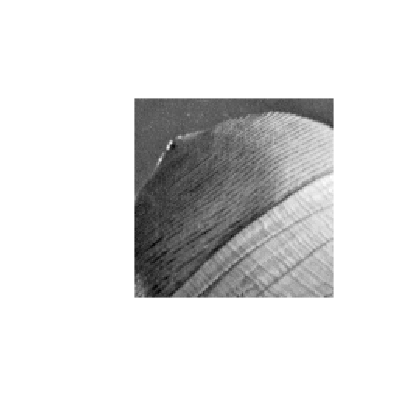

In [48]:
imageplot(f0)

Noise level $\si$.

In [49]:
sigma <- 0.04

Generate a noisy image $f=f_0+\epsilon$ where $\epsilon \times
\Nn(0,\si^2\text{Id}_N)$.

In [50]:
f <- as.cimg(f0) + sigma*as.cimg(rnorm(n**2))

Display $f$.

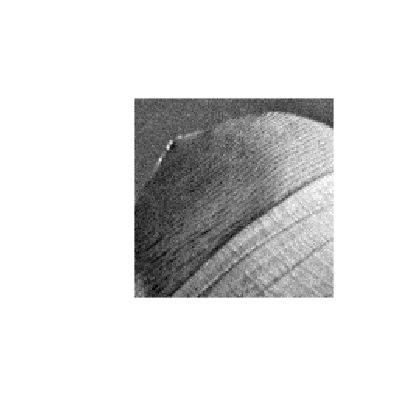

In [51]:
imageplot(clamp(f))

We denote $w$ to be the half width of the patches,
and $w_1=2w+1$ the full width.

In [52]:
w <- 3
w1 <- 2*w + 1

We set up large $(n,n,w_1,w_1)$ matrices to index the the X and Y
position of the pixel to extract.

Location of pixels to extract.

In [53]:
grid <- meshgrid_4d(1:n, 1:n, (-w):w, (-w):w)
X <- grid$X ; Y <- grid$Y ; dX <- grid$Z ; dY <- grid$S
X <- X + dX
Y <- Y + dY

We handle boundary condition by reflexion

In [54]:
X[X < 1] <- 2-X[X < 1] 
Y[Y < 1] <- 2-Y[Y < 1]
X[X > n] <- 2*n-X[X > n]
Y[Y > n] <- 2*n-Y[Y > n]

Patch extractor operator.

In [55]:
I <- (X-1) + (Y-1)*n
for (i in 1:(n%/%w)){
    for (j in 1:(n%/%w)){
        I[i,j,,] <- t(I[i,j,,])
    }
}

patch <- function(f){ array(as.vector(f)[I+1], dim(I)) }

Define the patch matrix $P$ of size $(n,n,w_1,w_1)$.
Each $P(i,j,:,:)$ represent an $(w_1,w_1)$ patch extracted around pixel
$(i,j)$ in the image.

In [56]:
P <- patch(f)

Display some example of patches.

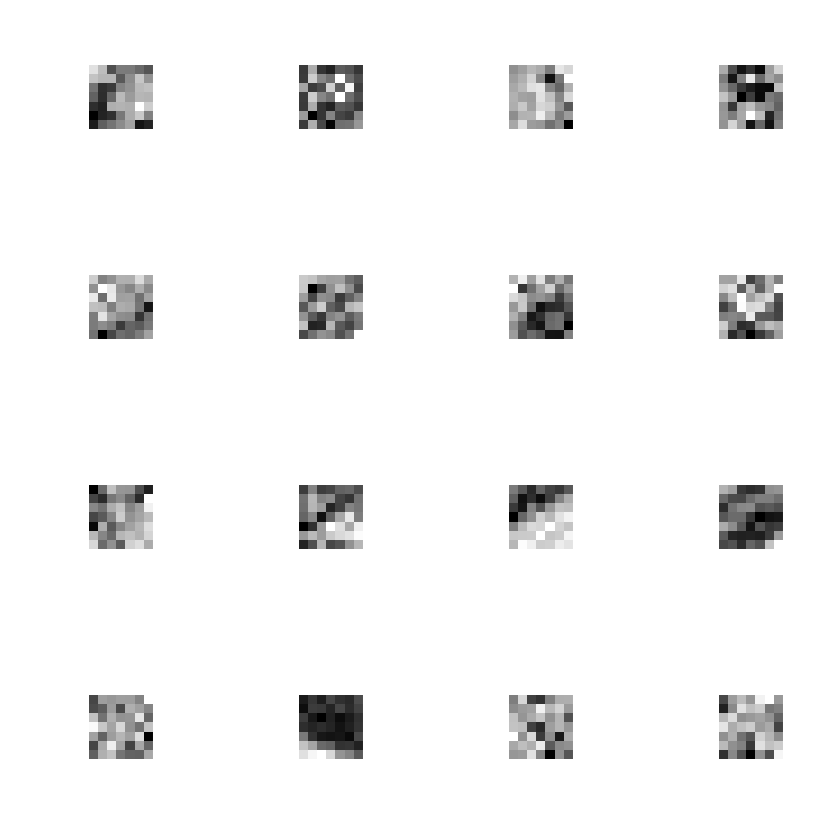

In [57]:
options(repr.plot.width=7, repr.plot.height=7)

for (i in 1:16){
    x <- sample(1:n, 1)
    y <- sample(1:n, 1)
    imageplot(P[x,y,,], "", c(4, 4, i))
}

Dimensionality Reduction with PCA
---------------------------------
Since NL-means type algorithms require the computation of many distances
between patches, it is advantagous to reduce the dimensionality of the
patch while keeping as much as possible of information.


Target dimensionality $d$.

In [58]:
d <- 25

A linear dimensionality reduction is obtained by Principal Component
Analysis (PCA) that projects the data on a small number of leading
direction of the covariance matrix of the patches.


Turn the patch matrix into an $(w_1*w_1,n*n)$ array, so that each $P(:,i)$
is a $w_1*w_1$ vector representing a patch.

In [59]:
resh <- function(P){ t(array(P, c(n*n,w1*w1))) }

Operator to remove the mean of the patches to each patch.

In [60]:
remove_mean <- function(Q){ Q - array(rep(apply(Q, 2, mean), each=w1*w1), c(w1*w1, n*n)) }

Compute the mean and the covariance of the points cloud representing the
patches.

In [61]:
P1 <- remove_mean(resh(P))
C <- P1 %*% t(P1)

Extract the eigenvectors, sorted by decreasing amplitude.

In [62]:
eg <- eigen(C)
D <- eg$values ; V <- eg$vectors
D <- D[order(-D)]
I <- order(-D)
V <- V[I,]

Display the decaying amplitude of the eigenvalues.

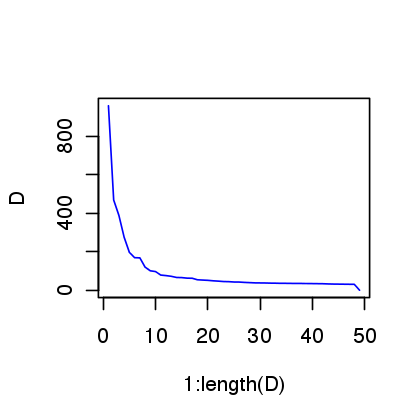

In [63]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

plot(1:length(D), D, "l", col="blue")

Display the leading eigenvectors - they look like Fourier modes.

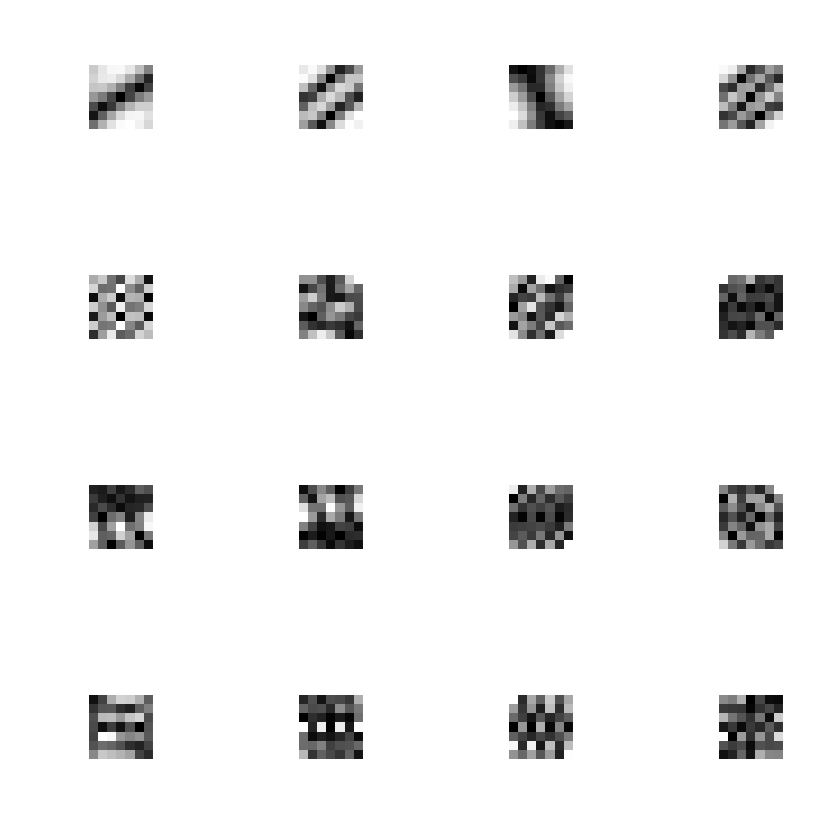

In [64]:
options(repr.plot.width=7, repr.plot.height=7)

for (i in 1:16){
    imageplot(abs(array(V[,i], c(w1,w1))), "", c(4,4,i))
}

Patch dimensionality reduction operator.

In [65]:
iresh <- function(Q){ array( t(Q), c(n,n,d) ) }
descriptor <- function(f){ iresh( t(V[, 1:d]) %*% remove_mean(resh(P)) ) }

Each $H(i,j,:)$ is a $d$-dimensional descriptor
of a patch.

In [66]:
H <- descriptor(f)

Non-local Filter
----------------
NL-means applies, an adaptive averaging kernel
is computed from patch distances to each pixel location.


We denote $H_{i} \in \RR^d$ the descriptor at pixel $i$.
We define the distance matrix
$$ D_{i,j} = \frac{1}{w_1^2}\norm{H_i-H_j}^2. $$



Operator to compute the distances $(D_{i,j})_j$ between the patch around $i=(i_1,i_2)$
and all the other ones.

In [67]:
distance <- function(i){ apply((H - array( rep(H[i[1],i[2],], each=n*n), dim(H) ))**2, c(1,2), sum)/(w1*w1) }

The non-local mean filter computes a denoised image $\tilde f$ as :

$$ \tilde f_i = \sum_j K_{i,j} f_j $$
where the weights $K$ are computed as :
$$ K_{i,j} = \frac{ \tilde K_{i,j} }{ \sum_{j'} \tilde K_{i,j'} }
      \qandq
   \tilde K_{i,j} = e^{-\frac{D_{i,j}}{2\tau^2}} . $$



The width $\tau$ of the Gaussian is very important and should be adapted to match
the noise level.



Compute and normalize the weight.

In [68]:
normalize <- function(K){ K/sum(K) }
kernel <- function(i,tau){ normalize(exp(-distance(i)/(2*tau**2))) }

Compute a typical example of kernel for some pixel position $(x,y)$.

In [69]:
tau <- 0.05
i <- c(84,73)
D <- distance(i)
K <- kernel(i, tau)

Display the squared distance and the kernel.

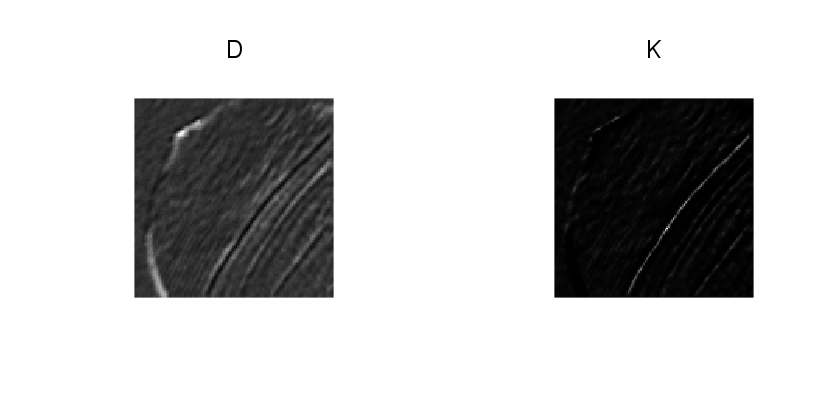

In [70]:
options(repr.plot.width=7, repr.plot.height=3.5)

imageplot(D, 'D', c(1, 2, 1))
imageplot(K, 'K', c(1, 2, 2))

Localizing the Non-local Means
------------------------------
We set a "locality constant" $q$ that set the maximum distance between
patches to compare. This allows to speed up computation, and makes
NL-means type methods semi-global (to avoid searching in all the image).

In [71]:
q <- 14

Using this locality constant, we compute the distance between patches
only within a window.
Once again, one should be careful about boundary conditions.

In [72]:
selection <- function(i){
    a <- clamp((i[1]-q):(i[1]+q), 0, n-1)
    b <- clamp((i[2]-q):(i[2]+q), 0, n-1)
    return( t(array(c(a,b), c(length(a), 2))) )
}

Compute distance and kernel only within the window.

In [73]:
distance_0 <- function(i, sel){
    H1 <- H[sel[1,]+1,,]
    H2 <- H1[,sel[2,]+1,]
    return(apply((H2 - array( rep(H[i[1]+1,i[2]+1,], each=length(sel[1,])*length(sel[2,])), dim(H2) ))**2, c(1,2), sum)/w1*w1)
}

distance <- function(i){ distance_0(i, selection(i)) }
kernel <- function(i, tau){ normalize(exp(-distance(i)/ (2*tau**2))) }

Compute a typical example of kernel for some pixel position $(x,y)$.

In [74]:
D <- distance(i)
K <- kernel(i, tau)

Display the squared distance and the kernel.

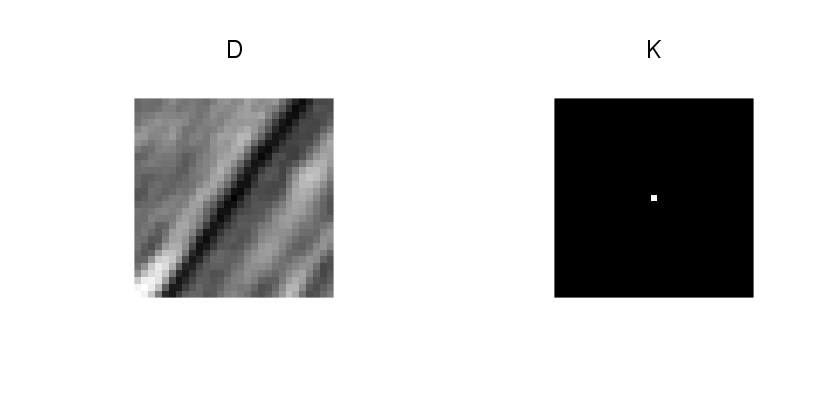

In [75]:
options(repr.plot.width=7, repr.plot.height=3.5)

imageplot(D, 'D', c(1, 2, 1))
imageplot(K, 'K', c(1, 2, 2))

The NL-filtered value at pixel $(x,y)$ is obtained by averaging the values
of $f$ with the weight $K$.

In [76]:
NLval_0 <- function(K,sel){
    f_temp <- f[sel[1,]+1,,,]
    return( sum(K*f_temp[, sel[2,]+1]) )
}

NLval <- function(i, tau){ 
    sel <- selection(i)
    K <- kernel(i, tau)
    return(NLval_0(K, sel)) }

We apply the filter to each pixel location
to perform the NL-means algorithm.

In [77]:
grid <- meshgrid_2d(0:(n-1), 0:(n-1))
Y <- grid$X ; X <- grid$Y

arrayfun <- function(f,X,Y){
    n <- dim(X)[1]
    p <- dim(Y)[1]
    R <- matrix(rep(0,n*p), c(n,p))
    for (k in 0:(n-1)){
        for (l in 0:(p-1)){
            R[k+1,l+1] <- f(k, l)
        }
    }
    return(R) }

NLmeans <- function(tau){ arrayfun(function(i1, i2){NLval(c(i1,i2), tau)}, X, Y) }

Display the result for some value of $\tau$.

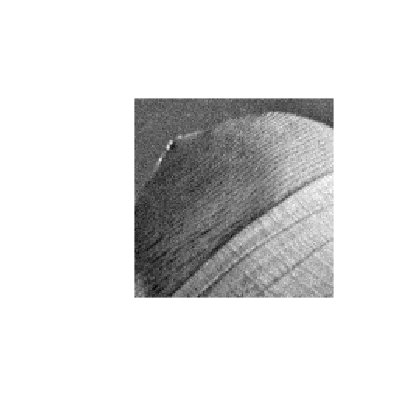

In [78]:
tau <- 0.03

options(repr.plot.width=3.5, repr.plot.height=3.5)
imageplot(NLmeans(tau))

__Exercise 1__

Compute the denoising result for several values of $\tau$ in order to
determine the optimal denoising that minimizes $\norm{\tilde f - f_0}$.

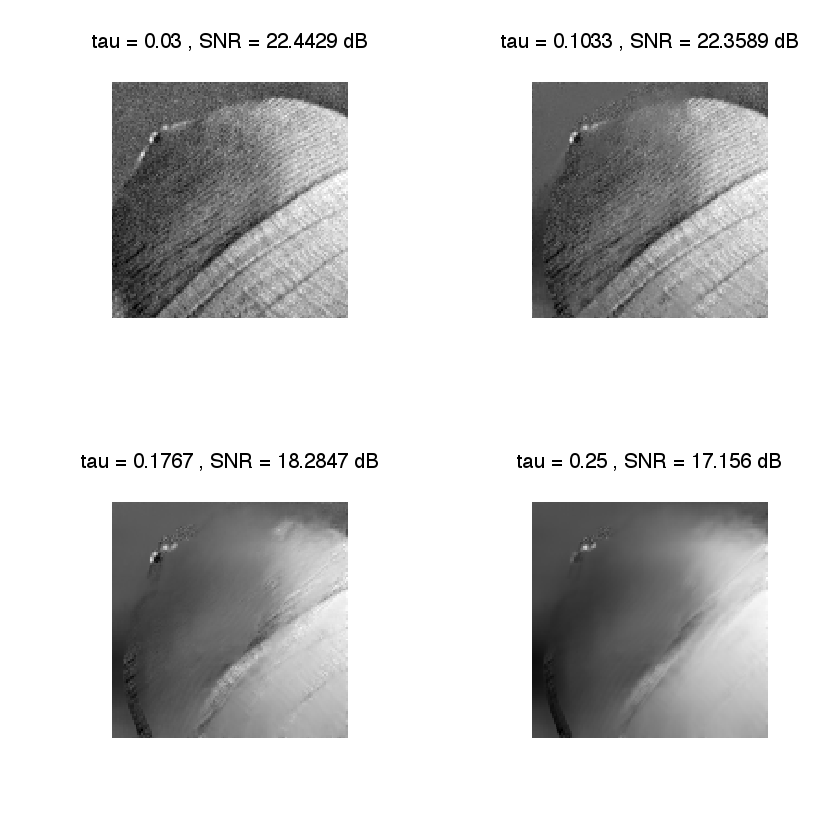

In [79]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/denoisingadv_6_nl_means/exo1.R")

In [80]:
## Insert your code here.

Display the best result.

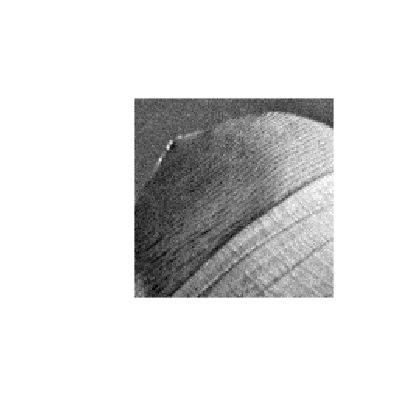

In [81]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

imageplot(clamp(fNL))

__Exercise 2__

Explore the influence of the $q$ and $w$ parameters.

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)

source("nt_solutions/denoisingadv_6_nl_means/exo2.R")

In [ ]:
## Insert your code here.

Bibliography
------------
<html><a name="biblio"></a></html>


* [BuaCoMoA05] Buades, B. Coll, J.f Morel, [A review of image denoising algorithms, with a new one][1], SIAM Multiscale Modeling and Simulation, Vol 4 (2), pp: 490-530, 2005.

[1]:http://dx.doi.org/10.1137/040616024